In [36]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

In [56]:
dataset = pd.read_csv('wandb_result2.csv')

In [96]:
len('- score_diff')

12

In [58]:
dataset.columns

Index(['Step', 'alpha: 1.5 - js', 'alpha: 1.5 - js__MIN',
       'alpha: 1.5 - js__MAX', 'alpha: 1.5 - score_diff',
       'alpha: 1.5 - score_diff__MIN', 'alpha: 1.5 - score_diff__MAX',
       'alpha: 1.5 - alpha', 'alpha: 1.5 - alpha__MIN',
       'alpha: 1.5 - alpha__MAX',
       ...
       'alpha: -0.9128276109695436 - alpha__MAX',
       'alpha: -0.9990000128746032 - js',
       'alpha: -0.9990000128746032 - js__MIN',
       'alpha: -0.9990000128746032 - js__MAX',
       'alpha: -0.9990000128746032 - score_diff',
       'alpha: -0.9990000128746032 - score_diff__MIN',
       'alpha: -0.9990000128746032 - score_diff__MAX',
       'alpha: -0.9990000128746032 - alpha',
       'alpha: -0.9990000128746032 - alpha__MIN',
       'alpha: -0.9990000128746032 - alpha__MAX'],
      dtype='object', length=226)

In [137]:
run_names, jss_, sigmas, klbs, klfs, alphas_, scores_diffs_ = [], [],[], [], [], [], []
for c in dataset.columns:
    if c[-7:] == '- sigma':
        run_names = c.split(" ")[0]
    elif c[-4:] == '- js':
        jss_.append(dataset[c].values)
    elif c[-13:] == '- kl_backward':
        klfs.append(dataset[c].values)
    elif c[-12:] == '- kl_forward':
        klbs.append(dataset[c].values)
    elif c[-12:] == '- score_diff':
        scores_diffs_.append(dataset[c].values)
    elif c[-7:] == '- alpha':
        alphas_.append(dataset[c].values[0])
step = dataset['Step'].values
scores_diffs_ = np.array(scores_diffs_)
        # reverse: KL(q,p) = KL(samples, true_samples) = KL(x_cur, target_sample) = kl_for
        # forward: KL(p,q) = KL(true_samples, samples) = kl_back

In [138]:
alphas, jss, scores_diffs = [],[],[]
for i in range(len(alphas_)):
    if alphas_[i]<1.:
        alphas.append(alphas_[i])
        jss.append(jss_[i])
        scores_diffs.append(scores_diffs_[i])
    

In [139]:
ind_of_stand = np.argwhere(np.array(alphas)==0)[0][0]

In [140]:
l_alphas = np.array(alphas)
l_alphas = (l_alphas-l_alphas.min())/(l_alphas.max()-l_alphas.min())

In [63]:
def moving_average(arr, window):
    # Calculate the number of elements to be averaged
    n = len(arr)
    
    # Initialize an empty list to store the moving averages
    moving_averages = []
    
    # Iterate over the array with a sliding window
    for i in range(n - window + 1):
        # Calculate the sum of the current window
        window_sum = sum(arr[i:i+window])
        
        # Calculate the average of the current window
        window_average = window_sum / window
        
        # Append the average to the list
        moving_averages.append(window_average)
    
    return moving_averages

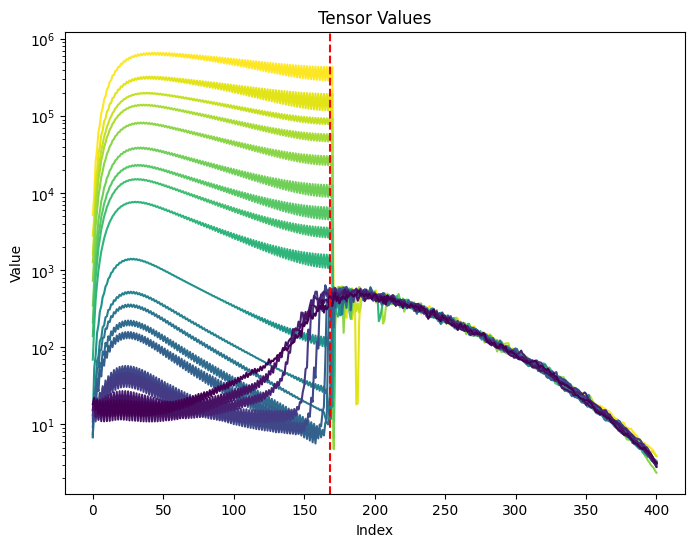

In [141]:
# Create a colormap object
cmap = plt.get_cmap('viridis')
# Plot the tensors as colored lines
plt.figure(figsize=(8, 6))
for i, js in enumerate(jss):
    plt.plot(step, js, color=cmap(l_alphas[i]))
# Customize the plot
plt.xlabel('Index')
plt.ylabel('Value')
# plt.xlim(0.05,150)
# plt.ylim(0,7)
plt.yscale('log')
plt.title('Tensor Values')
# plot vertical line at x=100
plt.axvline(x=168, color='r', linestyle='--')
plt.show()

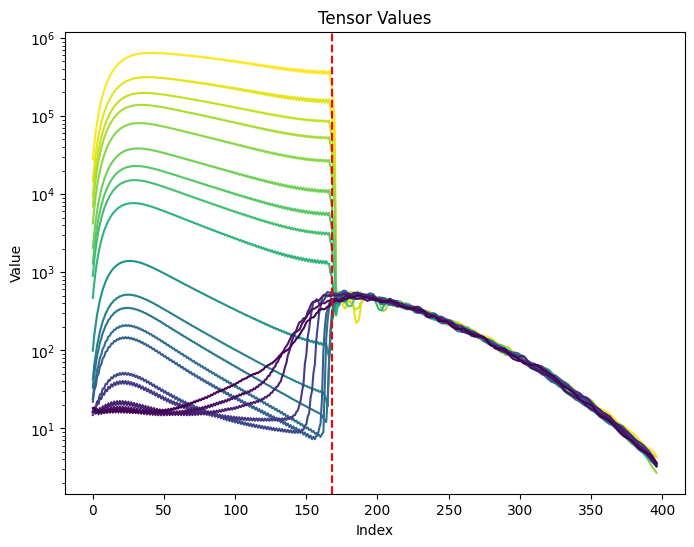

In [93]:
# Create a colormap object
cmap = plt.get_cmap('viridis')
# Plot the tensors as colored lines
plt.figure(figsize=(8, 6))
for i, js in enumerate(jss):
    # plt.plot(step, js, color=cmap(l_alphas[i]))
    plt.plot(step[:-4], moving_average(js, 5), color=cmap(l_alphas[i]))
# Customize the plot
plt.xlabel('Index')
plt.ylabel('Value')
# plt.xlim(0.05,150)
# plt.ylim(0,7)
plt.yscale('log')
plt.title('Tensor Values')
# plot vertical line at x=100
plt.axvline(x=168, color='r', linestyle='--')
plt.show()

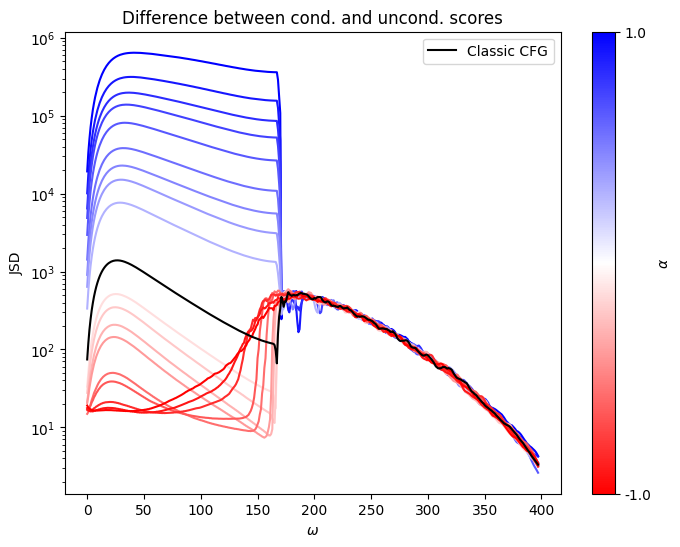

In [174]:
from scipy.signal import savgol_filter
cmap = plt.get_cmap('bwr')
# Plot the tensors as colored lines
fig, ax = plt.subplots(figsize=(8, 6))
for i, js in enumerate(jss):
    smooth_steps = 4
    if i!=ind_of_stand:
        ax.plot(step[:(-smooth_steps+1)], moving_average(js, smooth_steps), color=cmap(1-l_alphas[i]))
ax.plot(step[:(-smooth_steps+1)], moving_average(jss[ind_of_stand], smooth_steps), color='black', label='Classic CFG')
# Customize the plot
ax.set_xlabel(f'$\omega$')
ax.set_ylabel('JSD')
# ax.legend([f'Line {i+1}' for i in range(k)], loc='upper right')
# ax.set_xlim(0.05,150)
# ax.set_ylim(1,8)
ax.set_yscale('log')
ax.set_title('Difference between cond. and uncond. scores')
# Create a proxy artist for the colorbar
proxy_artist = plt.Line2D([0], [0], linestyle="none", marker='o', markersize=6, markerfacecolor=cmap(0.5))
# Add a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap.reversed()), ax=ax, label=f'$\\alpha$')

ticks = np.linspace(0, 1, 2)  # 5 ticks between 0 and 1
labels = [-1., 1.]

# Update the colorbar with custom ticks and labels
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)
plt.legend()
plt.savefig('paper_figs/diff1.pdf')
plt.show()

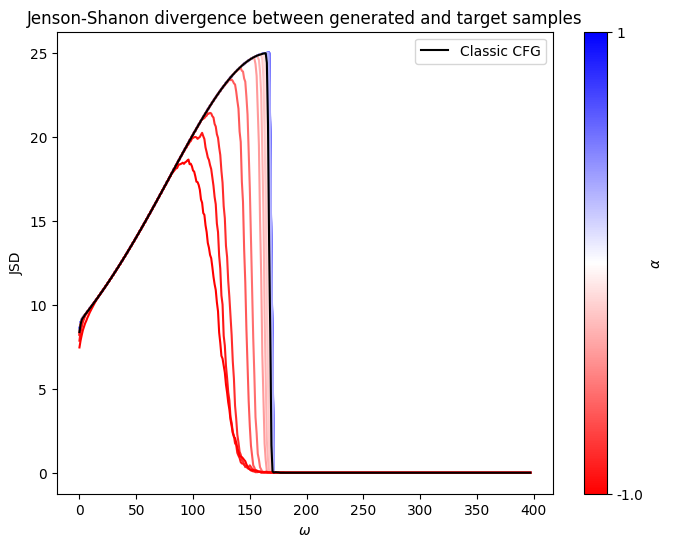

In [175]:
from scipy.signal import savgol_filter
cmap = plt.get_cmap('bwr')
# Plot the tensors as colored lines
fig, ax = plt.subplots(figsize=(8, 6))
for i, sc in enumerate(scores_diffs):
    smooth_steps = 4
    if i!=ind_of_stand:
        ax.plot(step[:(-smooth_steps+1)], moving_average(sc, smooth_steps), color=cmap(1-l_alphas[i]))
ax.plot(step[:(-smooth_steps+1)], moving_average(scores_diffs[ind_of_stand], smooth_steps), color='black', label='Classic CFG')
# Customize the plot
ax.set_xlabel(f'$\omega$')
ax.set_ylabel('JSD')
# ax.legend([f'Line {i+1}' for i in range(k)], loc='upper right')
# ax.set_xlim(0.05,150)
# ax.set_ylim(1,8)
# ax.set_yscale('log')
ax.set_title('Jenson-Shanon divergence between generated and target samples')
# Create a proxy artist for the colorbar
proxy_artist = plt.Line2D([0], [0], linestyle="none", marker='o', markersize=6, markerfacecolor=cmap(0.5))
# Add a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap.reversed()), ax=ax, label=f'$\\alpha$')

ticks = np.linspace(0, 1, 2)  # 5 ticks between 0 and 1
labels = [-1., 1]

# Update the colorbar with custom ticks and labels
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)
plt.legend()
plt.savefig('paper_figs/diff2.pdf')
plt.show()